In [1]:
import numpy as np
import cplex
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
np.random.seed(0)
random.seed(0)
n_stage, pcast, n_batch, n_machine_perstage = 3, 2, 8, 3
#n_stage, pcast, n_batch, n_machine_perstage = 3, 1, 3, 2
stage_name = ['steelmaking', 'refining', 'casting']
n_machine = dict(zip(stage_name, [n_machine_perstage for i in range(n_stage)]))
n_job = pcast * n_batch * n_machine['steelmaking']
assert(len(stage_name) == n_stage)

print("Number of stage:", n_stage)
print("Cast number of per machine:", pcast)
print("Number of job per cast:", n_batch)
print('Number of machine:', n_machine)
print('Number of job:', n_job)

assert(len(n_machine) == n_stage)

processtime = [random.randint(36,50) for i in range(n_job * n_stage)]
transittime = [random.randint(3,6) for i in range(n_stage - 1)]
su = 80
duedate = [0 for i in range(pcast * n_machine['casting'])]

penalty_coeff = 10
d_coeff = {'d1': 10, 'd2': 110}
coeff = [10 + 20 * i for i in range(n_stage - 1)]
print(processtime)
print(transittime)

Number of stage: 3
Cast number of per machine: 2
Number of job per cast: 8
Number of machine: {'steelmaking': 3, 'refining': 3, 'casting': 3}
Number of job: 48
[49, 42, 48, 50, 42, 36, 40, 44, 43, 42, 50, 48, 49, 40, 43, 41, 45, 50, 50, 39, 44, 38, 40, 38, 48, 37, 45, 48, 40, 50, 44, 47, 48, 45, 50, 38, 40, 37, 47, 37, 50, 49, 46, 41, 43, 44, 37, 41, 42, 41, 45, 46, 50, 39, 44, 43, 43, 49, 44, 40, 36, 48, 50, 44, 50, 36, 37, 47, 49, 42, 47, 49, 48, 46, 46, 36, 45, 43, 49, 49, 41, 39, 47, 41, 47, 49, 37, 39, 50, 45, 39, 39, 48, 38, 48, 44, 43, 37, 37, 41, 50, 44, 50, 43, 37, 40, 44, 40, 47, 37, 44, 41, 49, 50, 44, 39, 48, 45, 44, 45, 40, 43, 37, 45, 48, 42, 41, 45, 39, 40, 38, 39, 49, 38, 36, 45, 46, 40, 43, 37, 37, 46, 48, 38]
[4, 3]


In [3]:
class Subproblem_T():
    def __init__(self):
        self.n_dim = n_job * n_stage + 2 * pcast * n_machine['casting']
        self.variable_names = ['t' + str(i)  for i in range(self.n_dim)]
        self.duedate = self.compute_duedate()
        self.constraints_rows, self.rhs, self.n_per_constraints = self.set_constraints_byrows()
        self.senses = self.set_senses()
        self.opt_solution = []
        self.n_constraints = len(self.constraints_rows)
        self.cost_function_iterations = []
        
    def set_preceding_transfer_constraints(self):
        preceding_transfer_constraints = []
        for i in range(n_job * (n_stage - 1)):
            preceding_transfer_constraints.append([[self.variable_names[i], self.variable_names[i + n_job]], [1, -1]])

        rhs_transittime, rhs_processtime = [], processtime[0: n_job * (n_stage - 1)]
        for i in range(len(transittime)):
            rhs_transittime += [transittime[i]] * n_job
        rhs = [ - processtime[i] - rhs_transittime[i] for i in range(n_job * (n_stage - 1))]
        return preceding_transfer_constraints, rhs, rhs_processtime, rhs_transittime

    def set_process_continuous_constraints(self):
        process_continuous, adjacent_casts = [], []
        rhs_continuous_processtime, rhs_adjacent_casts = [], []
        assert(n_job * (n_stage - 1) % n_batch == 0)
        for i in range(n_job * (n_stage - 1), n_job * n_stage - 1):
            if (i + 1) % n_batch != 0:
                process_continuous.append([[self.variable_names[i], self.variable_names[i + 1]], [1, -1]])
                rhs_continuous_processtime.append(-processtime[i])
            else:
                if (i + 1) % (n_batch * pcast) != 0:
                    adjacent_casts.append([[self.variable_names[i], self.variable_names[i + 1]], [1, -1]])
                    rhs_adjacent_casts.append(- processtime[i] - su)
        return process_continuous, adjacent_casts, rhs_continuous_processtime, rhs_adjacent_casts 

    def set_additional_constraints(self):
        additional_constraints = []
        index = n_job * n_stage
        index_start = pcast * n_machine['casting']
        assert(n_job * (n_stage - 1) % n_batch == 0 and (index % n_batch == 0))
        batch = 0
        for i in range(n_job * (n_stage - 1), n_job * n_stage - 1):
            if i % n_batch == 0:
                additional_constraints.append([[self.variable_names[i], self.variable_names[index + batch], self.variable_names[index + batch + index_start]], [1, -1, 1]])
                batch += 1
        return additional_constraints
    
    def set_constraints_byrows(self):
        preceding_transfer_constraints, rhs_preceding_transfer, _, _ = self.set_preceding_transfer_constraints()
        process_continuous_constraints, adjacent_casts_constraints, rhs_continuous_processtime, rhs_adjacent_casts = self.set_process_continuous_constraints()
        additional_constraints = self.set_additional_constraints()
    
        rows = preceding_transfer_constraints + process_continuous_constraints + adjacent_casts_constraints + additional_constraints
        
        n_per_constraints = [len(preceding_transfer_constraints), len(process_continuous_constraints), len(adjacent_casts_constraints), len(additional_constraints)]
        
        rhs = rhs_preceding_transfer + rhs_continuous_processtime + rhs_adjacent_casts + self.duedate
        return rows, rhs, n_per_constraints
    
    def set_senses(self):
        s, senses = 'LELE', ''
        for i in range(len(self.n_per_constraints)):
            senses += s[i] * self.n_per_constraints[i]
        return senses
    
    def compute_duedate(self):
        duedate = [0 for i in range(pcast * n_machine['casting'])]
        duedate_start = [0 for i in range(n_machine['casting'])]
        n_cast = pcast * n_machine['casting']
        for i in range(n_machine['casting']):
            index = 0
            for j in range(n_stage - 1):
                duedate_start[i] += processtime[i * n_cast + index * n_job] + transittime[j]
                index += 1
        #print(duedate_start)
    
        for i in range(n_machine['casting']):
            duedate[i * pcast] = duedate_start[i]
            index_start = n_job * (n_stage - 1) + i * n_cast
            for j in range(1, pcast):
                duedate[i * pcast + j] = duedate[i * pcast + j - 1] + sum(processtime[index_start: index_start + n_batch]) + su
                index_start = index_start + n_batch
        return duedate
    
    def compute_obj_wait_time(self):
        obj_wait_time = np.zeros((n_stage, n_job))
        for i in range(n_stage - 1):
            for j in range(n_job):
                obj_wait_time[i + 1][j], obj_wait_time[i][j] = obj_wait_time[i + 1][j] + coeff[i], obj_wait_time[i][j] - coeff[i]
        obj_wait_time = obj_wait_time.reshape(1, n_stage * n_job)
        return np.hstack((obj_wait_time, np.zeros((1, self.n_dim - n_stage * n_job)))).tolist()[0]

    def compute_obj_casting(self):
        obj_casting = np.hstack((d_coeff['d1'] *  np.ones((1, pcast * n_machine['casting'])), d_coeff['d2'] * np.ones((1, pcast * n_machine['casting']))))
        obj_casting = np.hstack((np.zeros((1, n_job * n_stage)), obj_casting))
        return obj_casting.tolist()[0]
    
    def compute_obj_linear(self, lamd):
        obj_linear_wait_time = self.compute_obj_wait_time()
        obj_linear_casting = self.compute_obj_casting()
        obj_linear_F4_t = self.compute_F4_t(lamd)
        self.obj_linear = [obj_linear_wait_time[i] + obj_linear_casting[i] + obj_linear_F4_t[i] for i in range(self.n_dim)]
        return self.obj_linear
    
    def compute_F4_t(self, lamd):
        t_coeff = [0 for i in range((n_stage - 1) * n_job)]
        for i in range(n_job):
            for i1 in range(n_job):
                for j in range(n_stage - 1):
                    t1 = i + j * n_job                
                    for k in range(n_machine_perstage):
                        t2 = i + i1 * n_job + (j * n_machine_perstage + k) * n_job * n_job 
                        t3 = i1 + i * n_job + (j * n_machine_perstage + k) * n_job * n_job
                        t_coeff[t1] += lamd[t2] - lamd[t3]
        return t_coeff + [0] * (self.n_dim - len(t_coeff))
    
    def solve(self):
        self.subproblem_cplex = cplex.Cplex()
        self.subproblem_cplex.objective.set_sense(self.subproblem_cplex.objective.sense.minimize)
        
        ub  = [cplex.infinity] * self.n_dim
        lb  = [0] * self.n_dim
        self.subproblem_cplex.variables.add(obj = self.obj_linear, ub = ub, lb = lb, names = self.variable_names)
    
        rownames = ['c' + str(i)  for i in range(self.n_constraints)]

        self.subproblem_cplex.linear_constraints.add(lin_expr = self.constraints_rows, senses = self.senses, rhs = self.rhs, names = rownames)
        self.subproblem_cplex.solve()
        self.get_solvable_status()
        print ("Solution value:   ",  self.subproblem_cplex.solution.get_objective_value())
        self.get_optvalues()

    def write_model(self):
        self.subproblem_cplex.write('Subproblem_T.lp')
        
    def get_optvalues(self):
        self.obj_values = self.subproblem_cplex.solution.get_objective_value()
        self.opt_solution = []
        for i, x in enumerate(self.subproblem_cplex.solution.get_values()):
            if i < self.n_dim:
                self.opt_solution.append(x)
        self.cost_function_iterations.append(self.subproblem_cplex.solution.get_objective_value())
                
    def get_solvable_status(self):
        status = self.subproblem_cplex.solution.get_status()
        if status == self.subproblem_cplex.solution.status.unbounded:
            print("Model is unbounded")
        if status == self.subproblem_cplex.solution.status.infeasible:
            print("Model is infeasible")
        if status == self.subproblem_cplex.solution.status.infeasible_or_unbounded:
            print("Model is infeasible or unbounded")
            
    def plot_results(self):
        plt.figure()
        x = np.linspace(0, len(self.cost_function_iterations), len(self.cost_function_iterations))
        plt.plot(x, self.cost_function_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('cost function')
        plt.show()
        
    def output_results(self):
        with open('Subproblem_T_result.txt', 'w') as f:
            for i in range(n_job * n_stage):
                f.write(str(self.opt_solution[i * n_job:(i + 1) * n_job]))
                f.write('\n')

In [4]:
def compute_heuristic_xval(tval):
    xval = [0 for i in range((n_stage - 1) * n_job * n_job)]
    j = 0
    while (j < (n_stage - 1)):
        date = []
        for i in range(j * n_job, (j + 1) * n_job):
            date.append((tval[i],i))
        result = sorted(date)
        for i in range(n_job):
            job_index = result[i][1] - j * n_job
            t1 = i
            k = t1 % n_machine_perstage
            r = 0    
            while (t1 > n_machine_perstage - 1):
                r += 1
                t1 -= n_machine_perstage
            xval[job_index * n_job + j * n_job * n_job + k * n_batch * pcast + r] = 1
            t1 +=1
        j += 1
    return xval

In [5]:
lamd = np.zeros((n_stage - 1) * n_job * n_job * n_machine_perstage)
subproblem_t = Subproblem_T()
subproblem_t.compute_obj_linear(lamd)
subproblem_t.solve()
subproblem_t.write_model()
print(subproblem_t.obj_values)
x_init = compute_heuristic_xval(subproblem_t.opt_solution)       


CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 31 rows and 37 columns.
Aggregator did 90 substitutions.
Reduced LP has 26 rows, 29 columns, and 52 nonzeros.
Presolve time = 0.00 sec. (0.09 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =           480.000000
Iteration:    18   Dual objective     =         90690.000000
Solution value:    91210.0
91210.0


In [6]:
class List_Schedule(Subproblem_T):
    def __init__(self, xval):
        self.n_dim = n_job * n_stage + 2 * pcast * n_machine['steelmaking']
        self.variable_names = ['t' + str(i)  for i in range(self.n_dim)]
        self.xval = xval
        self.duedate = self.compute_duedate()
        self.constraints_rows, self.rhs, self.n_per_constraints = self.set_constraints_byrows()
        self.senses = self.set_senses()
        self.n_constraints = len(self.constraints_rows) 
        
    def compute_obj(self):
        t_coeff_w = self.compute_obj_wait_time()
        t_coeff_c = self.compute_obj_casting()
        t_coeff = [t_coeff_w[i] + t_coeff_c[i] for i in range(self.n_dim)]
        return t_coeff
    
    def set_machine_capacity_constraints(self):
        machine_capacity_constraints = []
        rhs_machine_capacity_processtime = []
        for i in range(n_job):
            for i1 in range(n_job):
                if i != i1:
                    for j in range(n_stage - 1):
                        t1 = i + j * n_job
                        t2 = i1 + j * n_job
                        for k in range(n_machine_perstage):
                            for r in range(n_batch * pcast - 1):
                                t3 = i * n_job + j * n_job * n_job + k * n_batch * pcast + r
                                t4 = i1 * n_job + j * n_job * n_job + k * n_batch * pcast + r + 1 
                                if self.xval[t3] == 1 and self.xval[t4] == 1:
                                    machine_capacity_constraints.append([[self.variable_names[t2], self.variable_names[t1]],[-1, 1]])
                                    rhs_machine_capacity_processtime.append(-processtime[t1]) 
        return machine_capacity_constraints, rhs_machine_capacity_processtime
    
    def set_constraints_byrows(self):
        machine_capacity_constraints, rhs_machine_capacity_processtime = self.set_machine_capacity_constraints()
        preceding_transfer_constraints, rhs_preceding_transfer, _, _ = self.set_preceding_transfer_constraints()
        process_continuous_constraints, adjacent_casts_constraints, rhs_continuous_processtime, rhs_adjacent_casts = self.set_process_continuous_constraints()
        additional_constraints = subproblem_t.set_additional_constraints()
    
        rows = machine_capacity_constraints + preceding_transfer_constraints + process_continuous_constraints + adjacent_casts_constraints + additional_constraints
        
        n_per_constraints = [len(machine_capacity_constraints), len(preceding_transfer_constraints), len(process_continuous_constraints), len(adjacent_casts_constraints), len(additional_constraints)]
        
        rhs = rhs_machine_capacity_processtime + rhs_preceding_transfer + rhs_continuous_processtime + rhs_adjacent_casts + self.duedate
        return rows, rhs, n_per_constraints
        
    def set_senses(self):
        s, senses = 'LLELE', ''
        for i in range(len(self.n_per_constraints)):
            senses += s[i] * self.n_per_constraints[i]
        return senses 
    
    def solve(self):
        self.List_Schedule = cplex.Cplex()
        self.List_Schedule.objective.set_sense(self.List_Schedule.objective.sense.minimize)
        
        ub = [cplex.infinity] * self.n_dim
        #ub = [1000] * self.n_dim
        self.List_Schedule.variables.add(obj = self.compute_obj(), ub = ub, names = self.variable_names)
    
        rownames = ['c' + str(i)  for i in range(self.n_constraints)]

        self.List_Schedule.linear_constraints.add(lin_expr = self.constraints_rows, senses = self.senses, rhs = self.rhs, names = rownames)
        self.List_Schedule.solve()
        self.get_solvable_status()
        self.get_optvalues()
        
    def get_optvalues(self):
        self.obj_values = self.List_Schedule.solution.get_objective_value()
        print ("Solution value:   ",  self.obj_values)
        self.opt_solution = []
        for i, x in enumerate(self.List_Schedule.solution.get_values()):
            if i < self.n_dim:
                self.opt_solution.append(x)
                
    def get_solvable_status(self):
        status = self.List_Schedule.solution.get_status()
        if status == self.List_Schedule.solution.status.unbounded:
            print("Model is unbounded")
        if status == self.List_Schedule.solution.status.infeasible:
            print("Model is infeasible")
        if status == self.List_Schedule.solution.status.infeasible_or_unbounded:
            print("Model is infeasible or unbounded")
            
    def write_model(self):
        self.List_Schedule.write('List_Schedule.lp')

In [7]:
class Dual_Problem():
    def __init__(self):
        self.lamd = np.array([0 for i in range((n_stage - 1) * n_job * n_job * n_machine_perstage)])
        self.M = 0
        self.xval = [0 for i in range((n_stage - 1) * n_job * n_machine_perstage)]
        self.yval = [0 for i in range((n_stage - 1) * n_job * n_job)]
        self.subgradients_init = np.array([1 for i in range((n_stage - 1) * n_job * n_job * n_machine_perstage)])
        self.subgradients = np.array([0 for i in range((n_stage - 1) * n_job * n_job * n_machine_perstage)])
        self.obj_values = 0
        self.obj_values_iterations = []
        self.subgradients_norm_iterations = []
        self.step_iterations = []
    
    def compute_subproblem_x(self):
        for j in range((n_stage - 1)):
            for i in range(n_job):
                date = []
                F_k = [0 for i in range(n_machine_perstage)]
                for k in range(n_machine_perstage):
                    for i1 in range(n_job):
                        t1 = i + i1 * n_job + (j * n_machine_perstage + k) * n_job * n_job 
                        t2 = i1 + i * n_job + (j * n_machine_perstage + k) * n_job * n_job
                        F_k[k] += self.lamd[t1] + self.lamd[t2]
                        date.append((F_k[k],k))
                result = sorted(date)
                self.xval[i + (j * n_machine_perstage + result[0][1]) * n_job] = 1
        return self.xval  

    def compute_subproblem_y(self):
        for i in range(n_job - 1):
            for i1 in range(i + 1, n_job):
                for j in range((n_stage - 1)):
                    F_1 = 0
                    F_2 = 0
                    for k in range(n_machine_perstage):
                        t1 = i + i1 * n_job + (j * n_machine_perstage + k) * n_job * n_job 
                        t2 = i1 + i * n_job + (j * n_machine_perstage + k) * n_job * n_job
                        F_1 += self.lamd[t1]
                        F_2 += self.lamd[t2]
                        if (F_1 < F_2):
                            self.yval[i + i1 * n_job + j * n_job * n_job] = 1
                            self.yval[i1 + i * n_job + j * n_job * n_job] = 0                        
                        else:
                            self.yval[i + i1 * n_job + j * n_job * n_job] = 0
                            self.yval[i1 + i * n_job + j * n_job * n_job] = 1                        
        return self.yval
    
    def compute_M(self):
        self.M = 0
        for i in range(n_job):
            for j in range(n_stage):
                self.M += processtime[i + j * n_job] 
        for j in range(n_stage - 1):        
            self.M +=transittime[j]
        return self.M
    
    def compute_subgradients(self):
        for i in range(n_job):
            for i1 in range(n_job):
                if i != i1:
                    for j in range(n_stage - 1):
                        t1 = i + j * n_job
                        t2 = i1 + j * n_job
                        for r in range(n_batch * pcast - 1):
                            for k in range(n_machine_perstage):
                                t3 = i + (j * n_machine_perstage + k) * n_job 
                                t4 = i1 + (j * n_machine_perstage + k) * n_job 
                                t5 = i1 + i * n_job + (j * n_machine_perstage + k) * n_job * n_job
                                t6 = i1 + i * n_job + j * n_job * n_job
                                self.subgradients[t5] += (subproblem_t.opt_solution[t2] - subproblem_t.opt_solution[t1] - processtime[t1] + self.M * (3 - self.xval[t3] - self.xval[t4] - self.yval[t6]))
        return self.subgradients
    
    def compute_relaxed_problem_obj(self):
        self.obj_values = 0
        t_coeff_w = subproblem_t.compute_obj_wait_time()
        t_coeff_c = subproblem_t.compute_obj_casting()
        t_coeff = [t_coeff_w[i] + t_coeff_c[i] for i in range(len(t_coeff_w))]
        for i in range(len(t_coeff)):
            self.obj_values += t_coeff[i] * subproblem_t.opt_solution[i] 
        for i in range(n_job):
            for i1 in range(n_job): 
                if i != i1:
                    for j in range(n_stage - 1):
                        t1 = i + j * n_job
                        t2 = i1 + j * n_job
                        for k in range(n_machine_perstage):
                            t3 = i + (j * n_machine_perstage + k) * n_job 
                            t4 = i1 + (j * n_machine_perstage + k) * n_job 
                            t5 = i + i1 * n_job + j * n_job * n_job
                            t6 = i1 + i * n_job + (j * n_machine_perstage + k) * n_job * n_job
                            #print(subproblem_t.opt_solution[t2], subproblem_t.opt_solution[t1],  self.xval[t3], self.xval[t4], self.yval[t5])
                            self.obj_values -= self.lamd[t6] * (subproblem_t.opt_solution[t2] - subproblem_t.opt_solution[t1] - processtime[t1] + self.M * (3 - self.xval[t3] - self.xval[t4] - self.yval[t5]))
        self.obj_values_iterations.append(self.obj_values)
    
    def update_lamd(self):
        self.lamd = self.lamd - self.step * self.subgradients
        self.lamd = np.maximum(self.lamd, 0)
        return self.lamd
    
    def plot_results(self, lower_bound_iterations):
        plt.figure()
        x = np.linspace(0, len(self.obj_values_iterations), len(self.obj_values_iterations))
        plt.plot(x, self.obj_values_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('cost function of dual problem')
        plt.savefig("obj_values_iterations.jpg")
        plt.show()
        
        plt.figure()
        x = np.linspace(0, len(lower_bound_iterations), len(lower_bound_iterations))
        plt.plot(x, lower_bound_iterations)
        plt.xlabel('iteration times')
        plt.ylabel('lower_bound_iterations')
        plt.savefig("lower_bound_iterations.jpg")
        plt.show()
        

In [8]:
list_schedule = List_Schedule(x_init)
list_schedule.solve()
print(list_schedule.obj_values)
t_init = list_schedule.opt_solution

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Aggregator did 45 substitutions.
Reduced LP has 192 rows, 111 columns, and 390 nonzeros.
Presolve time = 0.00 sec. (0.12 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =          1420.000000
Iteration:    62   Dual infeasibility =           310.000000
Iteration:    94   Dual objective     =         90550.000000
Iteration:   155   Dual objective     =        105680.000000
Solution value:    106710.0
106710.0


In [9]:
lower_bound_iterations = []
dual_problem = Dual_Problem()
dual_problem.compute_subgradients()
for i in range((n_stage - 1) * n_job * n_job):
    if (dual_problem.subgradients[i] > 0 and abs(dual_problem.lamd[i]) < 1e-8):
        dual_problem.subgradients[i] = 0
dual_problem.compute_M()
dual_problem.compute_relaxed_problem_obj()
delta0 = (-dual_problem.obj_values + list_schedule.obj_values)
G = np.linalg.norm(dual_problem.subgradients)
R0 = (-dual_problem.obj_values + list_schedule.obj_values) / G
frec0 = -dual_problem.obj_values
frec1 = 10e+100
pf0 = 10e+100
L = 1
R = R0 / L
delta = delta0 / L
gdelta = -delta / dual_problem.obj_values
nf = 0
N = 4
tempf = [0 for i in range(N)]
tempf0 = [0 for i in range(N)]
ts = time.clock() 
while True:
    tempf[nf] = -dual_problem.obj_values
    nf +=1
    if (nf >= N):
        nf = 0
        tempf1 = 0
        tempf2 = 0
        for i in range(0, N - 2, 2):
            tempf1 += abs((tempf[i + 2] - tempf[i]) / tempf[i])
        for i in range(1, N - 2, 2):
            tempf2 += abs((tempf[i + 2] - tempf[i]) / tempf[i])
        if (tempf1 / (N / 2 - 1) < 10e-3 or tempf2 / (N / 2 - 1) < 10e-3):
            sigma = R + 1
        if (-dual_problem.obj_values < frec1):
            frec1 = -dual_problem.obj_values
        if (list_schedule.obj_values < pf0):
            pf0 = list_schedule.obj_values
        disGap = list_schedule.obj_values - dual_problem.obj_values
        if (delta > disGap):
            delta = disGap
        if (-dual_problem.obj_values < frec0 - 0.5 * delta):
            sigma = 0
            frec0 = frec1
        elif (sigma > R):
            sigma = 0
            L+=1
            delta = delta * 0.8
            R = R0 / (L + 1)
            frec0 = frec1
        flev = frec0 - delta
        gdelta = delta / frec0
        G = np.linalg.norm(dual_problem.subgradients)
        dual_problem.step = 1.2 * (-dual_problem.obj_values - flev) / G**2
        dual_problem.update_lamd()
 
        subproblem_t = Subproblem_T()
        subproblem_t.compute_obj_linear(dual_problem.lamd)
        subproblem_t.solve()
        dual_problem.compute_subproblem_x()
        dual_problem.compute_subproblem_y()
        dual_problem.compute_relaxed_problem_obj()
        lower_bound_iterations.append(dual_problem.obj_values)

        dual_problem.compute_subgradients()
        for i in range((n_stage - 1) * n_job * n_job):
            if (dual_problem.subgradients[i] > 0 and abs(dual_problem.lamd[i]) < 1e-8):
                dual_problem.subgradients[i] = 0

        sigma += dual_problem.step * np.linalg.norm(dual_problem.subgradients)
        if (abs(gdelta) < 10e-4):
            break   
x_init = compute_heuristic_xval(subproblem_t.opt_solution)
list_schedule = List_Schedule(x_init)
list_schedule.solve()
gap = 2 * (list_schedule.obj_values - dual_problem.obj_values)/(list_schedule.obj_values + dual_problem.obj_values)
print("low bound = ", dual_problem.obj_values, "upper bound = ", list_schedule.obj_values, "gap = ",gap)   
 
running_time = time.clock() - ts
print("running time is", running_time) 

CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 31 rows and 37 columns.
Aggregator did 90 substitutions.
Reduced LP has 26 rows, 29 columns, and 52 nonzeros.
Presolve time = 0.00 sec. (0.09 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =           479.692218
Iteration:    21   Dual objective     =         90004.228332
Solution value:    90588.59527002808
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 31 rows and 37 columns.
Aggregator did 90 substitutions.
Reduced LP has 26 rows, 29 columns, and 52 nonzeros.
Presolve time = 0.00 sec. (0.09 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =           479.705643
Iteration:    21   Dual objective     =         90027.875823
Solution value:    90610.1025157659
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 31 rows and 37 columns.
Aggregator did 90 subs

LP Presolve eliminated 31 rows and 37 columns.
Aggregator did 90 substitutions.
Reduced LP has 26 rows, 29 columns, and 52 nonzeros.
Presolve time = 0.00 sec. (0.09 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =           479.717528
Iteration:    21   Dual objective     =         90049.319991
Solution value:    90629.58284706208
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 31 rows and 37 columns.
Aggregator did 90 substitutions.
Reduced LP has 26 rows, 29 columns, and 52 nonzeros.
Presolve time = 0.01 sec. (0.09 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =           479.717540
Iteration:    21   Dual objective     =         90049.343930
Solution value:    90629.6045701136
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 31 rows and 37 columns.
Aggregator did 90 substitutions.
Reduced LP has 26 rows, 29 columns, and 52 nonzeros.
Presolve tim

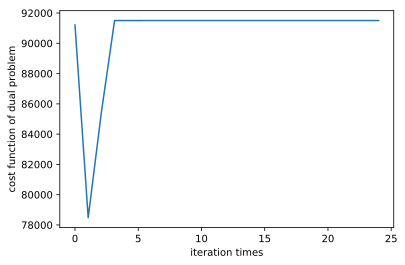

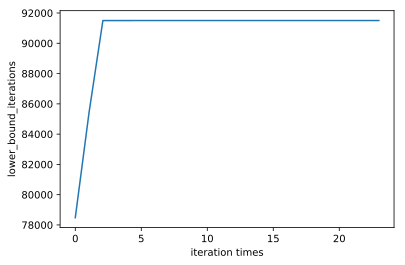

In [10]:
subproblem_t.output_results()
subproblem_t.write_model()
dual_problem.plot_results(lower_bound_iterations)